In [30]:
!pip install -q imbalanced-learn
!pip install -q xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import pandas as pd
import numpy as np

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import RFE, SelectKBest, f_classif

In [34]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [36]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
    average_precision_score,
    roc_auc_score,
    f1_score,
    make_scorer
)

In [37]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [38]:
file_path = 'creditcard - menor balanceado.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset carregado com sucesso!")
    print(f"Formato dos dados (linhas, colunas): {df.shape}")

    print("\n--- Primeiras 5 linhas ---")
    print(df.head())

    print("\n--- Informações das Colunas (Tipos e Nulos) ---")
    df.info()

except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
    print("Por favor, verifique se o nome do arquivo está correto e se você fez o upload para o Colab.")

Dataset carregado com sucesso!
Formato dos dados (linhas, colunas): (1759, 31)

--- Primeiras 5 linhas ---
       Time        V1        V2        V3        V4        V5        V6  \
0   82450.0  1.314539  0.590643 -0.666593  0.716564  0.301978 -1.125467   
1   50554.0 -0.798672  1.185093  0.904547  0.694584  0.219041 -0.319295   
2   55125.0 -0.391128 -0.245540  1.122074 -1.308725 -0.639891  0.008678   
3  116572.0 -0.060302  1.065093 -0.987421 -0.029567  0.176376 -1.348539   
4   90434.0  1.848433  0.373364  0.269272  3.866438  0.088062  0.970447   

         V7        V8        V9       V10       V11       V12       V13  \
0  0.388881 -0.288390 -0.132137 -0.597739 -0.325347 -0.216435  0.084204   
1  0.495236  0.139269 -0.760214  0.170547  0.821998  0.468322 -0.057550   
2 -0.701304 -0.027315 -2.628854  2.051312  0.575866 -0.594037  1.097880   
3  0.775644  0.134843 -0.149734 -1.238598 -0.841133 -0.586472 -0.779620   
4 -0.721945  0.235983  0.683491  1.166335  1.297531 -1.920966  1.88


Boas notícias: Não há dados nulos no dataset.

--- Distribuição das Classes (Fraude vs. Legítimo) ---
Transações Legítimas (Classe 0): 1267 (72.03%)
Transações Fraudulentas (Classe 1): 492 (27.9704%)
Total de Transações: 1759


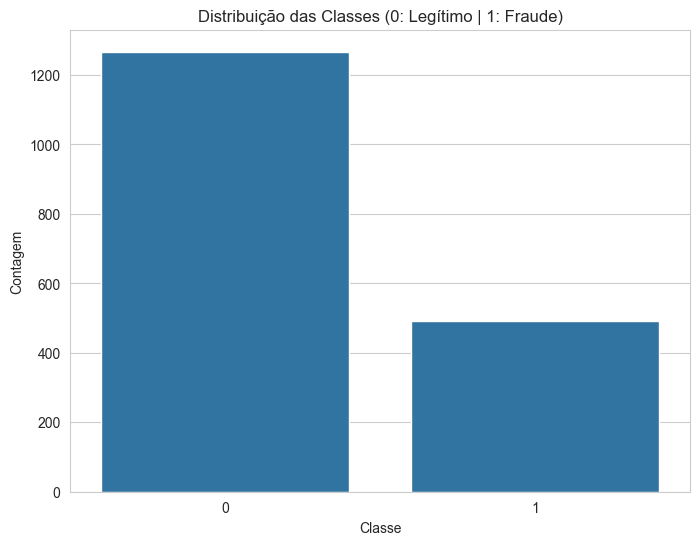


--- Análise das Features 'Amount' e 'Time' ---


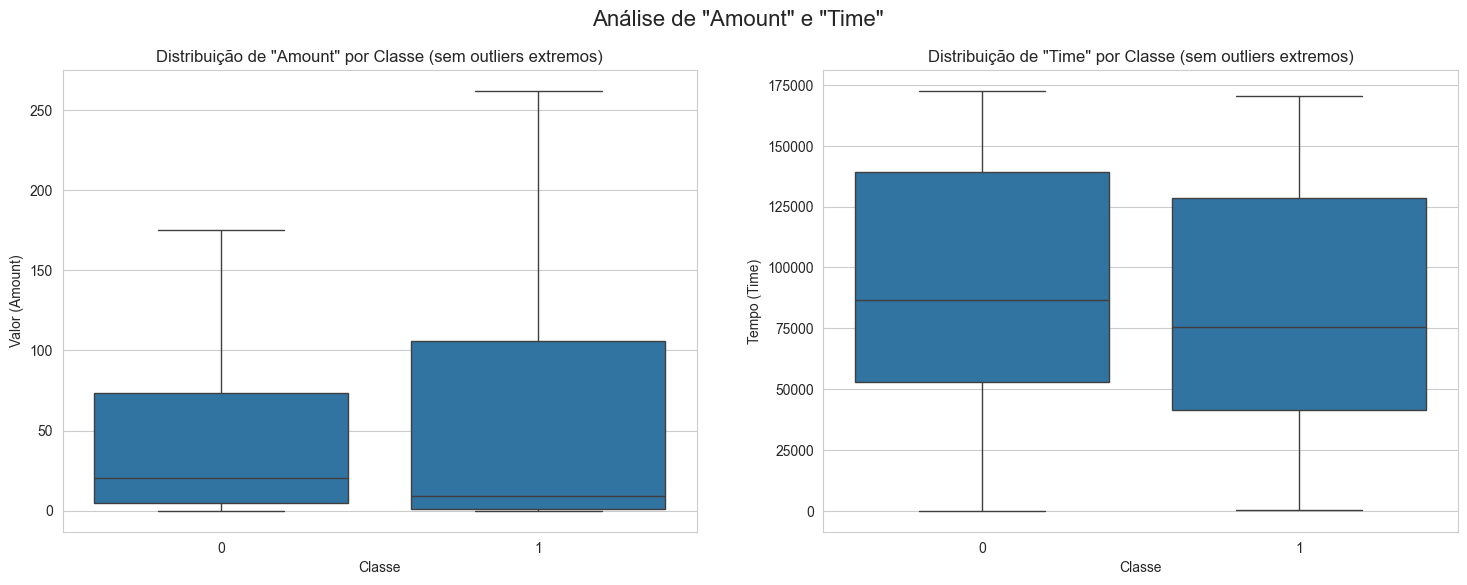

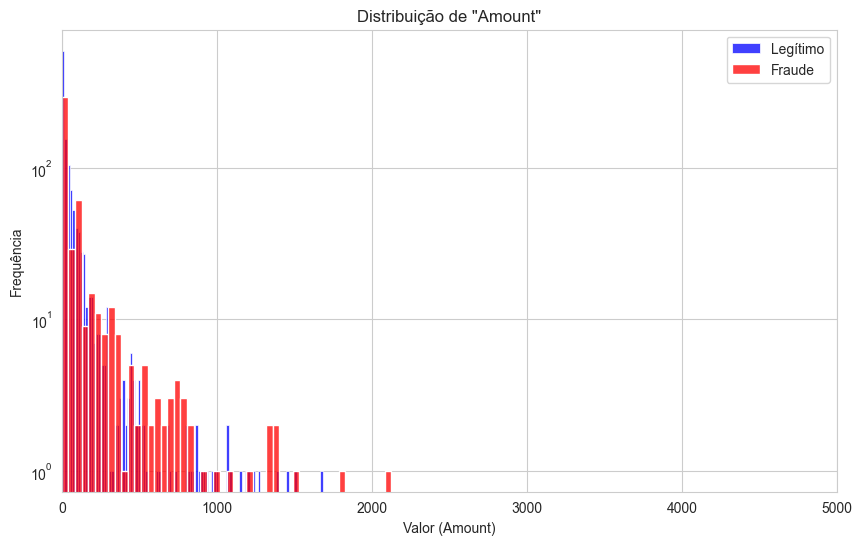


Observação: As features 'Amount' e 'Time' possuem escalas muito diferentes das features V1-V28.
Elas precisarão ser normalizadas/padronizadas no pré-processamento.


In [39]:

if df.isnull().sum().any():
    print("\nAVISO: Existem dados nulos! Será preciso tratá-los.")
    print(df.isnull().sum())
else:
    print("\nBoas notícias: Não há dados nulos no dataset.")

if 'Class' in df.columns:
    print("\n--- Distribuição das Classes (Fraude vs. Legítimo) ---")
    class_dist = df['Class'].value_counts()
    total_transacoes = len(df)

    fraude_percent = (class_dist[1] / total_transacoes) * 100
    legit_percent = (class_dist[0] / total_transacoes) * 100

    print(f"Transações Legítimas (Classe 0): {class_dist[0]} ({legit_percent:.2f}%)")
    print(f"Transações Fraudulentas (Classe 1): {class_dist[1]} ({fraude_percent:.4f}%)")
    print(f"Total de Transações: {total_transacoes}")

    plt.figure(figsize=(8, 6))
    sns.countplot(x='Class', data=df)
    plt.title('Distribuição das Classes (0: Legítimo | 1: Fraude)')
    plt.xlabel('Classe')
    plt.ylabel('Contagem')
    plt.show()

else:
    print("\nAVISO: Coluna 'Class' não encontrada. Ajuste o nome da coluna alvo no código.")



features_to_check = ['Amount', 'Time']
if all(col in df.columns for col in features_to_check) and 'Class' in df.columns:

    print("\n--- Análise das Features 'Amount' e 'Time' ---")

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    sns.boxplot(x='Class', y='Amount', data=df, ax=axes[0], showfliers=False)
    axes[0].set_title('Distribuição de "Amount" por Classe (sem outliers extremos)')
    axes[0].set_ylabel('Valor (Amount)')
    axes[0].set_xlabel('Classe')

    sns.boxplot(x='Class', y='Time', data=df, ax=axes[1], showfliers=False)
    axes[1].set_title('Distribuição de "Time" por Classe (sem outliers extremos)')
    axes[1].set_ylabel('Tempo (Time)')
    axes[1].set_xlabel('Classe')

    plt.suptitle('Análise de "Amount" e "Time"', fontsize=16)
    plt.show()


    plt.figure(figsize=(10, 6))
    sns.histplot(df[df['Class'] == 0]['Amount'], bins=100, color='blue', label='Legítimo', kde=False)
    sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', label='Fraude', kde=False)
    plt.title('Distribuição de "Amount"')
    plt.xlabel('Valor (Amount)')
    plt.ylabel('Frequência')
    plt.legend()
    plt.xlim(0, 5000)
    plt.yscale('log')
    plt.show()

    print("\nObservação: As features 'Amount' e 'Time' possuem escalas muito diferentes das features V1-V28.")
    print("Elas precisarão ser normalizadas/padronizadas no pré-processamento.")

elif 'Amount' in df.columns:
    print("\nAVISO: Coluna 'Time' não encontrada. Analisando apenas 'Amount'.")


else:
    print("\nAVISO: Colunas 'Amount' e/ou 'Time' não encontradas. Pulando a análise de distribuição delas.")

In [40]:

if 'Amount' in df.columns and 'Time' in df.columns:
    print("Aplicando RobustScaler nas colunas 'Amount' e 'Time'...")

    df_scaled = df.copy()

    rob_scaler = RobustScaler()

    df_scaled['scaled_amount'] = rob_scaler.fit_transform(df_scaled['Amount'].values.reshape(-1, 1))
    df_scaled['scaled_time'] = rob_scaler.fit_transform(df_scaled['Time'].values.reshape(-1, 1))

    df_scaled.drop(['Time', 'Amount'], axis=1, inplace=True)

    print("Colunas 'Amount' e 'Time' padronizadas e substituídas por 'scaled_amount' e 'scaled_time'.")

    if 'Class' in df_scaled.columns:
        target_col = df_scaled.pop('Class')
        df_scaled['Class'] = target_col
    else:
        print("ERRO: Coluna 'Class' não encontrada. Verifique o nome da sua coluna alvo.")

else:
    print("AVISO: Colunas 'Amount' e/ou 'Time' não encontradas. Pulando a padronização.")
    df_scaled = df.copy()



if 'Class' in df_scaled.columns:
    X = df_scaled.drop('Class', axis=1)
    y = df_scaled['Class']

    print(f"\nFeatures (X) shape: {X.shape}")
    print(f"Alvo (y) shape: {y.shape}")



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print("\nDados divididos em conjuntos de treino e teste.")
    print(f"Formato X_train: {X_train.shape} | Formato X_test: {X_test.shape}")

    print("\nVerificando proporção da classe no treino:")
    print(y_train.value_counts(normalize=True))

    print("\nVerificando proporção da classe no teste:")
    print(y_test.value_counts(normalize=True))
    print("\nAs proporções de treino e teste devem ser idênticas.")

else:
    print("ERRO CRÍTICO: Não foi possível definir X e y pois a coluna 'Class' não foi encontrada.")

Aplicando RobustScaler nas colunas 'Amount' e 'Time'...
Colunas 'Amount' e 'Time' padronizadas e substituídas por 'scaled_amount' e 'scaled_time'.

Features (X) shape: (1759, 30)
Alvo (y) shape: (1759,)

Dados divididos em conjuntos de treino e teste.
Formato X_train: (1231, 30) | Formato X_test: (528, 30)

Verificando proporção da classe no treino:
Class
0    0.720552
1    0.279448
Name: proportion, dtype: float64

Verificando proporção da classe no teste:
Class
0    0.719697
1    0.280303
Name: proportion, dtype: float64

As proporções de treino e teste devem ser idênticas.


Iniciando a Seleção de Atributos (Feature Selection)...
Isto será feito USANDO APENAS o conjunto de TREINO (X_train, y_train).

--- Método 1: Feature Importance (Random Forest) ---
Top 15 features mais importantes segundo o Random Forest:
          feature  importance
13            V14    0.207549
9             V10    0.137972
16            V17    0.111296
3              V4    0.096680
10            V11    0.075278
2              V3    0.067208
11            V12    0.066838
15            V16    0.045832
6              V7    0.026547
1              V2    0.024300
20            V21    0.013735
8              V9    0.012198
18            V19    0.009829
0              V1    0.009140
28  scaled_amount    0.008730


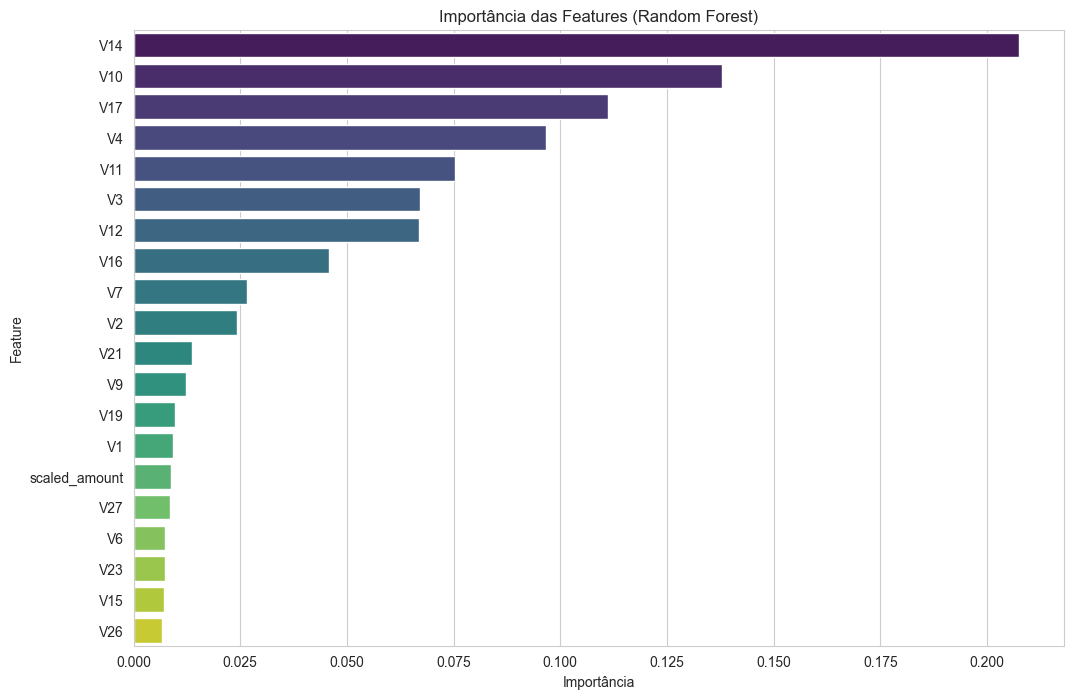


--- Método 2: SelectKBest (Teste Estatístico) ---
Top 15 features com maior score estatístico (SelectKBest):
   feature        score
13     V14  2388.253205
11     V12  1542.389748
3       V4  1516.790591
10     V11  1371.409194
9      V10  1065.069138
15     V16   903.408446
16     V17   797.859257
2       V3   789.553738
8       V9   670.568204
1       V2   514.914554
6       V7   497.337341
17     V18   397.568415
0       V1   373.913555
4       V5   272.862645
5       V6   220.475955


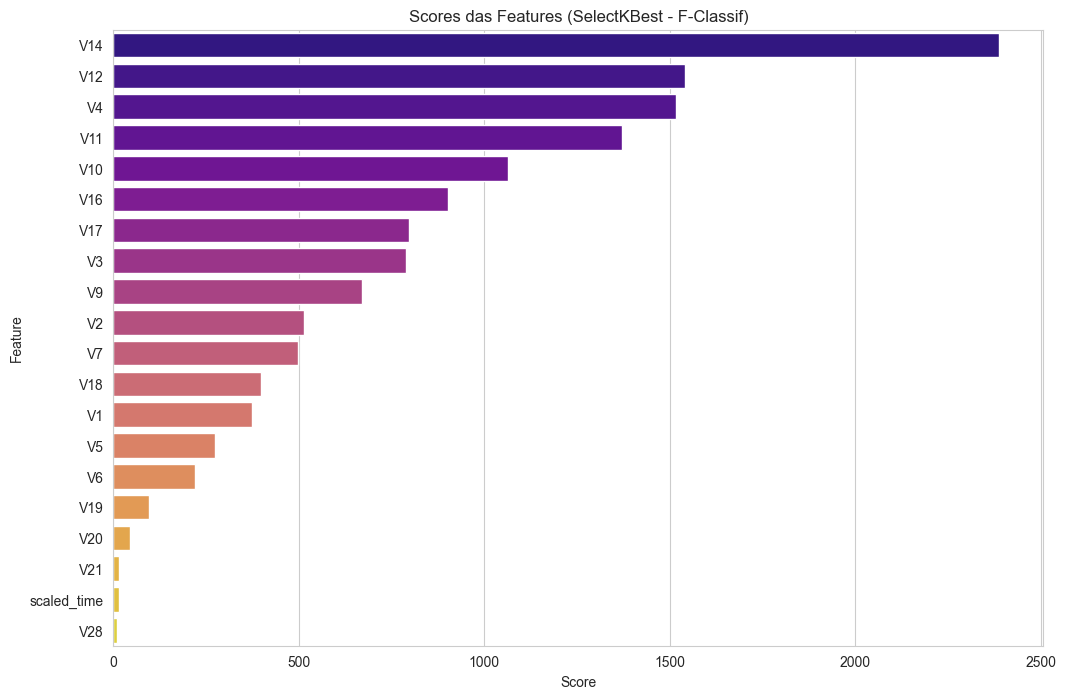

In [41]:


print("Iniciando a Seleção de Atributos (Feature Selection)...")
print("Isto será feito USANDO APENAS o conjunto de TREINO (X_train, y_train).\n")


print("--- Método 1: Feature Importance (Random Forest) ---")


rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)


feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 features mais importantes segundo o Random Forest:")
print(feature_importances.head(15))


plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importances.head(20),
    palette='viridis'
)
plt.title('Importância das Features (Random Forest)')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()


print("\n--- Método 2: SelectKBest (Teste Estatístico) ---")


k_best_selector = SelectKBest(score_func=f_classif, k=15)
k_best_selector.fit(X_train, y_train)

feature_scores = pd.DataFrame({
    'feature': X_train.columns,
    'score': k_best_selector.scores_
}).sort_values('score', ascending=False)

print("Top 15 features com maior score estatístico (SelectKBest):")
print(feature_scores.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(
    x='score',
    y='feature',
    data=feature_scores.head(20),
    palette='plasma'
)
plt.title('Scores das Features (SelectKBest - F-Classif)')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

In [42]:

selected_features = [
    'V14', 'V12', 'V4', 'V11', 'V10',
    'V16', 'V17', 'V3', 'V9', 'V2',
    'V7', 'V18', 'V1', 'V5', 'V6'
]

print(f"Decisão: Mantendo {len(selected_features)} features selecionadas com base na Etapa 4.")
print(selected_features)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nNovos formatos após seleção:")
print(f"Formato X_train_selected: {X_train_selected.shape}")
print(f"Formato X_test_selected: {X_test_selected.shape}")



print("\nAplicando SMOTE no conjunto de treino selecionado...")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)


print("Balanceamento com SMOTE concluído.")
print(f"\nFormato X_train original (selecionado): {X_train_selected.shape} | Formato y_train original: {y_train.shape}")
print(f"Formato X_train 'resampled': {X_train_resampled.shape} | Formato y_train 'resampled': {y_train_resampled.shape}")

print("\nVerificando proporção da classe após SMOTE:")

print(pd.Series(y_train_resampled).value_counts(normalize=True))

Decisão: Mantendo 15 features selecionadas com base na Etapa 4.
['V14', 'V12', 'V4', 'V11', 'V10', 'V16', 'V17', 'V3', 'V9', 'V2', 'V7', 'V18', 'V1', 'V5', 'V6']

Novos formatos após seleção:
Formato X_train_selected: (1231, 15)
Formato X_test_selected: (528, 15)

Aplicando SMOTE no conjunto de treino selecionado...
Balanceamento com SMOTE concluído.

Formato X_train original (selecionado): (1231, 15) | Formato y_train original: (1231,)
Formato X_train 'resampled': (1774, 15) | Formato y_train 'resampled': (1774,)

Verificando proporção da classe após SMOTE:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [43]:


print("Iniciando o treinamento dos modelos...")

X_train_final = X_train_resampled
y_train_final = y_train_resampled


models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),


    'SVM': SVC(random_state=42, probability=True)
}

print("Treinando os seguintes modelos nos dados balanceados (com SMOTE e Feature Selection):")

for model_name, model in models.items():
    print(f"  - Treinando {model_name}...")
    model.fit(X_train_final, y_train_final)
    print(f"    ... {model_name} treinado com sucesso!")

print("\n--- Treinamento de todos os modelos concluído ---")
print("Os modelos agora estão prontos na variável 'models'.")

Iniciando o treinamento dos modelos...
Treinando os seguintes modelos nos dados balanceados (com SMOTE e Feature Selection):
  - Treinando LogisticRegression...
    ... LogisticRegression treinado com sucesso!
  - Treinando KNeighborsClassifier...
    ... KNeighborsClassifier treinado com sucesso!
  - Treinando DecisionTree...
    ... DecisionTree treinado com sucesso!
  - Treinando RandomForest...
    ... RandomForest treinado com sucesso!
  - Treinando XGBoost...
    ... XGBoost treinado com sucesso!
  - Treinando SVM...
    ... SVM treinado com sucesso!

--- Treinamento de todos os modelos concluído ---
Os modelos agora estão prontos na variável 'models'.


In [44]:


print("Iniciando o Tuning de Hiperparâmetros para RandomForest e XGBoost...")
print("Usando RandomizedSearchCV (n_iter=20) com 5-Fold Cross-Validation.")
print("O objetivo é maximizar o F1-Score para a classe 'Fraude' (pos_label=1).\n")


X_train_final = X_train_resampled
y_train_final = y_train_resampled


f1_scorer = make_scorer(f1_score, pos_label=1)


cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


rf_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


xgb_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

print("--- 1. Tunando o RandomForest ---")
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_grid,
    n_iter=20,
    scoring=f1_scorer,
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_random_search.fit(X_train_final, y_train_final)

print(f"\nMelhor F1-Score para RandomForest (em CV): {rf_random_search.best_score_:.4f}")
print(f"Melhores Parâmetros: {rf_random_search.best_params_}")


print("\n--- 2. Tunando o XGBoost ---")
xgb_random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_distributions=xgb_grid,
    n_iter=20,
    scoring=f1_scorer,
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_random_search.fit(X_train_final, y_train_final)

print(f"\nMelhor F1-Score para XGBoost (em CV): {xgb_random_search.best_score_:.4f}")
print(f"Melhores Parâmetros: {xgb_random_search.best_params_}")


best_rf = rf_random_search.best_estimator_
best_xgb = xgb_random_search.best_estimator_

models['RandomForest_Tuned'] = best_rf
models['XGBoost_Tuned'] = best_xgb

print("\n--- Tuning Concluído ---")
print("Modelos 'RandomForest_Tuned' e 'XGBoost_Tuned' foram salvos.")

Iniciando o Tuning de Hiperparâmetros para RandomForest e XGBoost...
Usando RandomizedSearchCV (n_iter=20) com 5-Fold Cross-Validation.
O objetivo é maximizar o F1-Score para a classe 'Fraude' (pos_label=1).

--- 1. Tunando o RandomForest ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhor F1-Score para RandomForest (em CV): 0.9725
Melhores Parâmetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

--- 2. Tunando o XGBoost ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhor F1-Score para XGBoost (em CV): 0.9710
Melhores Parâmetros: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

--- Tuning Concluído ---
Modelos 'RandomForest_Tuned' e 'XGBoost_Tuned' foram salvos.
